<a href="https://colab.research.google.com/github/nimahamidi/random_projects/blob/main/random_no1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read Dataset from Google Drive (First Dataset)

In [69]:
from google.colab import drive
drive.flush_and_unmount()  # Unmounts
drive.mount('/content/drive')

import pandas as pd
import os

dir_path = '/content/drive/MyDrive'
file_name = 'Protocol_Zeta.xlsx'

file_path = os.path.join(dir_path, file_name)
excel_file = pd.ExcelFile(file_path)
sheet_names = excel_file.sheet_names

Mounted at /content/drive


# Read and Process Data (First data)

In [70]:
import matplotlib.pyplot as plt

def fix_names(df):
  df = df.rename(columns={'mean\nMech. \nLayer': 'avrg_hight'})
  df = df.rename(columns={'density\n@\nfull size': 'density'})
  return df

def vis(col):
  df[col].value_counts(normalize=True)
  df[col].dropna().hist(bins=100)  # drop NaN values for plotting
  plt.xlabel('Your Column')
  plt.ylabel('Count')
  plt.title(f'Distribution of {col}')
  plt.show()


help_dictionary = {'Catalyst':['Type', 'Sides', 'Fe'],
                   'Pre-activation':['H2', 'pressure', 'Temp.', 'speed'],
                   'CVD':['H2.1', 'C2H2', 'H2O', 'pressure.1','Temp..1', 'speed.1'],
                   'Evaluation':['Side 2', 'Side 1', 'SEM', 'thickn.\n[µm]',
                                 'thickn.\n[µm].1', 'thickn.\n[µm].2', 'mean\nMech. \nLayer',
                                 'total', 'i side', 'a side', 'Set', 'density\n@\n9x9 cm² ',
                                 'density\n@\nfull size', 'mass\nper area']}

feaature = help_dictionary['CVD']

df = pd.read_excel(file_path, sheet_name='Summary 2024, 2025')
df = df.drop([0, 1])
df = fix_names(df)

# 1. Prepare and clean data
df_filtered = df[
    (df['Temp..1'] > 620) & (df['Temp..1'] < 700) &
    (df['speed.1'] < 5) &
    (df['avrg_hight'] < 140)
]

df_model = df_filtered[['Temp..1', 'speed.1', 'avrg_hight', 'density']].dropna()

X = df_model[['Temp..1', 'speed.1']]
y = df_model[['avrg_hight', 'density']]

# Modeling Functions

In [79]:
# 1. Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

def modelPoly(X, y, degree=3, visPred=False):

  # 3. Standardize Inputs
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  # 4. Polynomial Feature Expansion
  poly = PolynomialFeatures(degree=degree, include_bias=False)
  X_poly = poly.fit_transform(X_scaled)

  # 5. Train/Test Split
  X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

  # 6. Train Polynomial Regression Model
  model = LinearRegression()
  model.fit(X_train, y_train)

  # X_test = X_train
  # y_test = y_train
  # 7. Evaluate the model
  y_pred = model.predict(X_test)

  print('=== Polynomial Regression Model Performance ===')
  print(f'Degree of Freedom: {degree}')
  print(f'R2 Score: {r2_score(y_test, y_pred):.2f}')
  print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}')

  # 8. Solve for Desired Output

  # Define desired targets
  desired_avrg_hight = 80  # <- set your goal
  desired_density = 0.06     # <- set your goal

  # Solve for scaled inputs
  A = model.coef_  # (2, features)
  b = model.intercept_  # (2,)

  # Since now we have a *polynomial* model, solving exactly becomes complex.
  # Instead, we can set up an optimization problem to minimize the error.

  from scipy.optimize import minimize

  # Define the loss function to minimize
  def loss(X_scaled_guess):
      X_scaled_poly = poly.transform([X_scaled_guess])
      y_pred = model.predict(X_scaled_poly)[0]
      return np.sum((y_pred - np.array([desired_avrg_hight, desired_density]))**2)

  # Initial guess: center (zero) in standardized space
  initial_guess = [0, 0]

  # Minimize
  result = minimize(loss, initial_guess, method='BFGS')

  # Get the solution
  X_scaled_target = result.x

  # Inverse transform to real Temp and Speed
  X_target = scaler.inverse_transform([X_scaled_target])
  temp_target, speed_target = X_target[0]

  print('=== Predicted Input Settings (Polynomial Model) ===')
  print(f'for hight: {desired_avrg_hight} & density: {desired_density}')
  print(f'Required Temperature: {temp_target:.2f}')
  print(f'Required Speed(/Time): {speed_target:.2f}')
  print(f'--------------------------------------------------------------')

  if visPred:
    y_pred = model.predict(X_test)
    vis_prediction(y, y_pred, y_test)

  return model

def vis_prediction(y, y_pred, y_test):
  for i, col in enumerate(y.columns):
    plt.figure(figsize=(6,4))
    plt.scatter(y_test[col], y_pred[:, i])
    plt.xlabel('True ' + col)
    plt.ylabel('Predicted ' + col)
    plt.title(f'True vs Predicted {col}')
    plt.grid(True)
    plt.plot([y_test[col].min(), y_test[col].max()], [y_test[col].min(), y_test[col].max()], 'k--')
    plt.show()

def visDataset(X, y):
  fig, axs = plt.subplots(1, 4, figsize=(20, 4))  # 1 row, 4 columns

  # Plot Time
  axs[0].hist(X.iloc[:, 0], bins=20)
  axs[0].set_xlabel('Time (Speed)')
  axs[0].set_ylabel('Count')
  axs[0].set_title('Time Distribution')
  axs[0].grid(True)

  # Plot Temp
  axs[1].hist(X.iloc[:, 1], bins=20)
  axs[1].set_xlabel('Temp')
  axs[1].set_ylabel('Count')
  axs[1].set_title('Tempreture Distribution')
  axs[1].grid(True)

  # Plot Bulk Density

  axs[2].hist(y.iloc[:, 0], bins=20)
  axs[2].set_xlabel('Bulk Density (g/cm³)')
  axs[2].set_ylabel('Count')
  axs[2].set_title('Bulk Density Distribution')
  axs[2].grid(True)

  # Plot Height
  axs[3].hist(y.iloc[:, 1], bins=20)
  axs[3].set_xlabel('CNT Height (μm)')
  axs[3].set_ylabel('Count')
  axs[3].set_title('CNT Height Distribution')
  axs[3].grid(True)

  plt.show()


# Run modeling for First Dataset

=== Polynomial Regression Model Performance ===
Degree of Freedom: 1
R2 Score: 0.05
Mean Squared Error: 240.31
=== Predicted Input Settings (Polynomial Model) ===
for hight: 80 & density: 0.06
Required Temperature: 575.88
Required Speed(/Time): 0.05
--------------------------------------------------------------


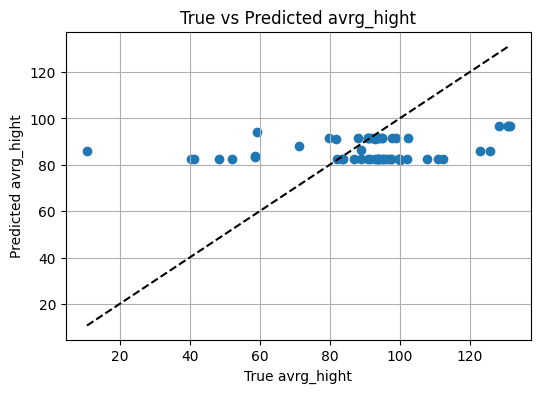

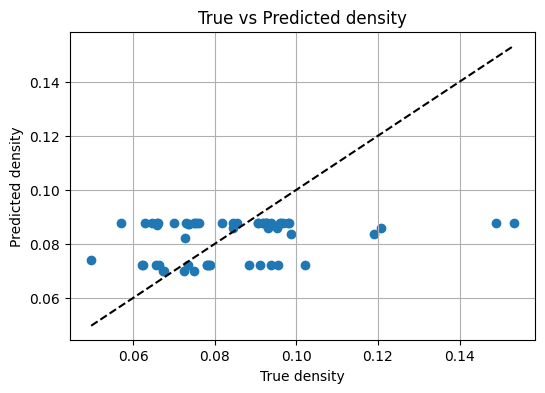

=== Polynomial Regression Model Performance ===
Degree of Freedom: 10
R2 Score: 0.16
Mean Squared Error: 206.68
=== Predicted Input Settings (Polynomial Model) ===
for hight: 80 & density: 0.06
Required Temperature: 636.86
Required Speed(/Time): 0.35
--------------------------------------------------------------


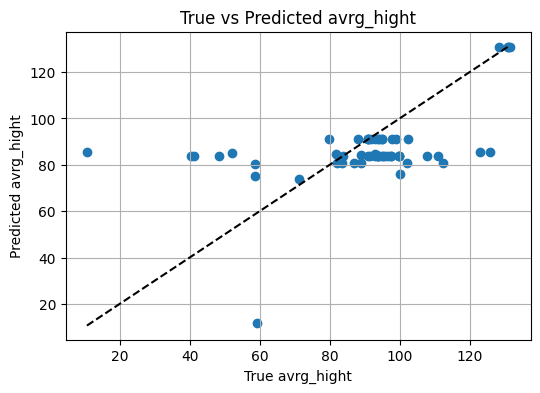

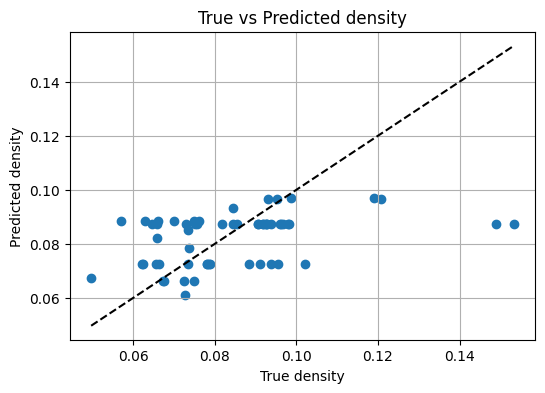

In [82]:
for deg in [1,10]:
  model = modelPoly(X, y, degree=deg, visPred=True) # visPred True will visualize the prediction, set it False to not plot them

# Visualize the dataset (first dataset)

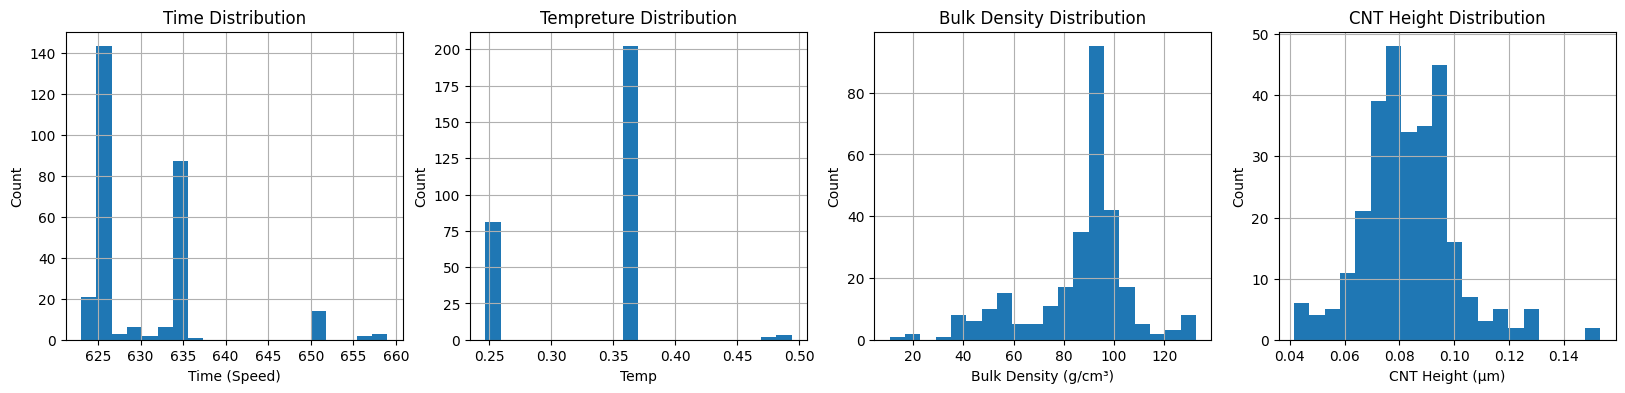

In [83]:
visDataset(X, y)

# Read Dataset from Google Drive (Second Dataset)

In [84]:
from google.colab import drive
drive.flush_and_unmount()  # Unmounts
drive.mount('/content/drive')

import pandas as pd
import os

dir_path = '/content/drive/MyDrive/Zeta_data'
file_name = 'Experiment_plan.xlsx'

file_path = os.path.join(dir_path, file_name)
excel_file = pd.ExcelFile(file_path)
sheet_names = excel_file.sheet_names

Mounted at /content/drive


In [85]:
import pandas as pd

sheet_names = ['04-01',
 '05-01',
 '06-01',
 '07-1',
 '08-1',
 '09-1',
 'Oct-2024',
 'Nov-2024',
 'Dec-2024',
 'Jan-2024',
 'Feb-2025',
 'March-2025',
 'April-2025']

def create_df():
  initial_df = pd.DataFrame()
  for sheet_name in sheet_names:
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    if 'Set Temp' in df.columns:
      df = df.rename(columns={'Set Temp': 'Temp °C'})
    if 'Bulk Density' in df.columns:
      df = df.rename(columns={'Bulk Density': 'Bulk Density (g/cm3)'})
    if 'CNT height (avg)' in df.columns:
      df = df.rename(columns={'CNT height (avg)': 'CNT height (µm avg)'})
    initial_df = pd.concat([initial_df, df], ignore_index=True)
  return initial_df

df = create_df()
df_filtered = df[['Temp °C', 'Time', 'CNT height (µm avg)', 'Bulk Density (g/cm3)']].dropna()
df_filtered = df_filtered[(df_filtered['Bulk Density (g/cm3)'] > 0) &
                            (df_filtered['Bulk Density (g/cm3)'] < 0.1)&
                            (df_filtered['CNT height (µm avg)'] < 200)]

df_model = df_filtered

X = df_model[['Temp °C', 'Time']]
y = df_model[['CNT height (µm avg)', 'Bulk Density (g/cm3)']]

# Run Modeling for Second Dataset

=== Polynomial Regression Model Performance ===
Degree of Freedom: 5
R2 Score: 0.18
Mean Squared Error: 429.89
=== Predicted Input Settings (Polynomial Model) ===
for hight: 80 & density: 0.06
Required Temperature: 624.98
Required Speed(/Time): 13.44
--------------------------------------------------------------


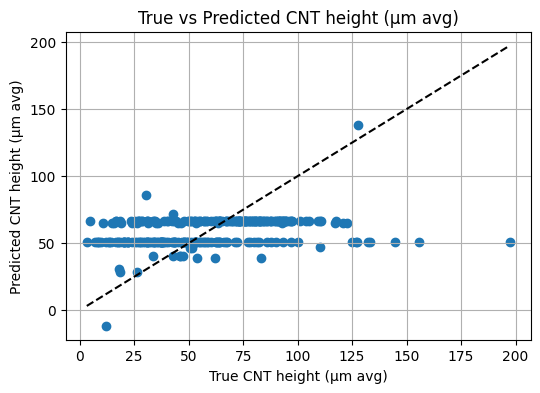

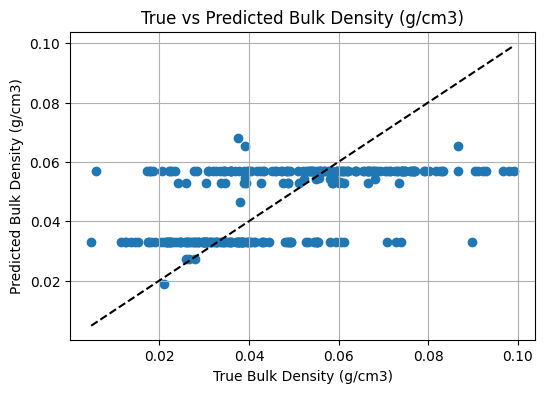

=== Polynomial Regression Model Performance ===
Degree of Freedom: 7
R2 Score: -0.32
Mean Squared Error: 879.27
=== Predicted Input Settings (Polynomial Model) ===
for hight: 80 & density: 0.06
Required Temperature: 629.38
Required Speed(/Time): 11.05
--------------------------------------------------------------


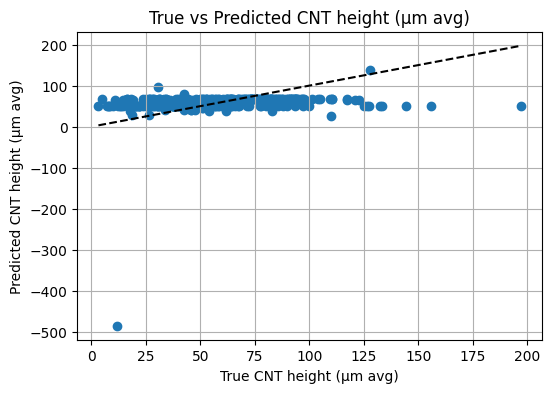

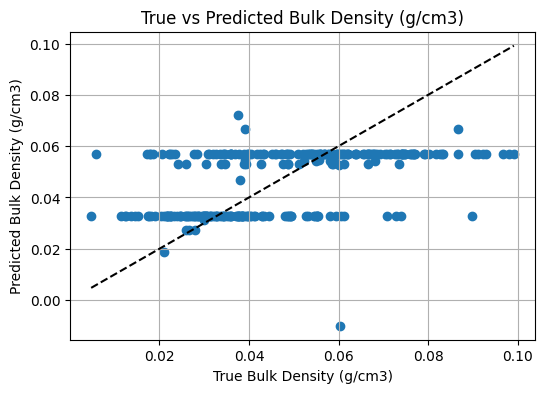

In [88]:
for deg in [5,7]:
  model = modelPoly(X, y, degree=deg, visPred=True) # visPred True will visualize the prediction, set it False to not plot them

# Visualize Dataset for Secod Dataset

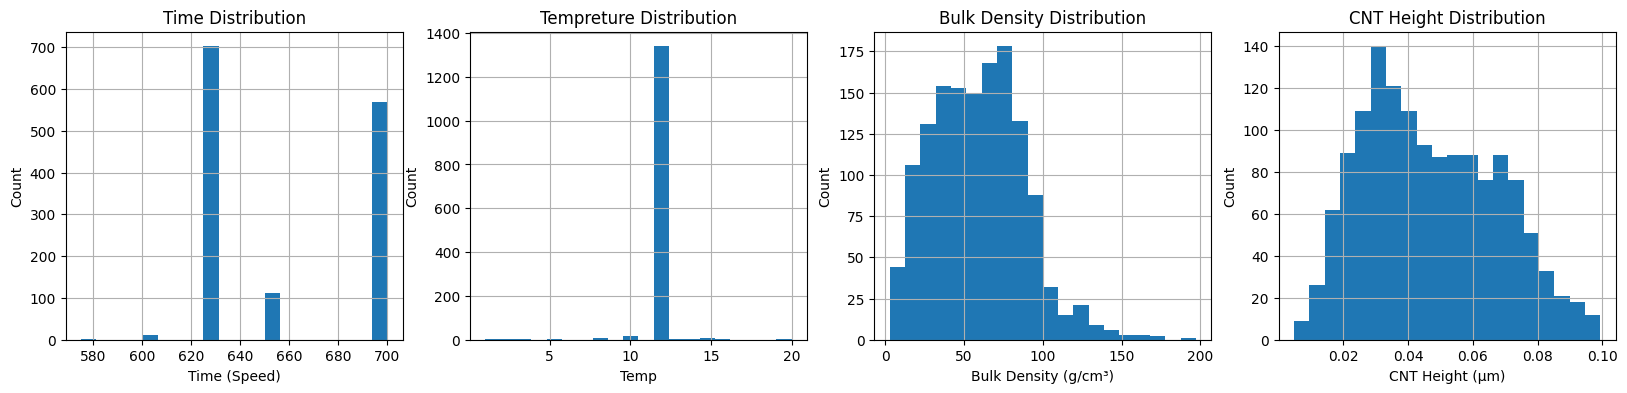

In [89]:
visDataset(X, y)